In [1]:
# !pip install -U transformers
# !pip install -U accelerate 
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")

In [3]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


text          0
label         0
label_name    0
dtype: int64

In [5]:
df['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

## Dataset Analysis

In [6]:
import matplotlib.pyplot as plt

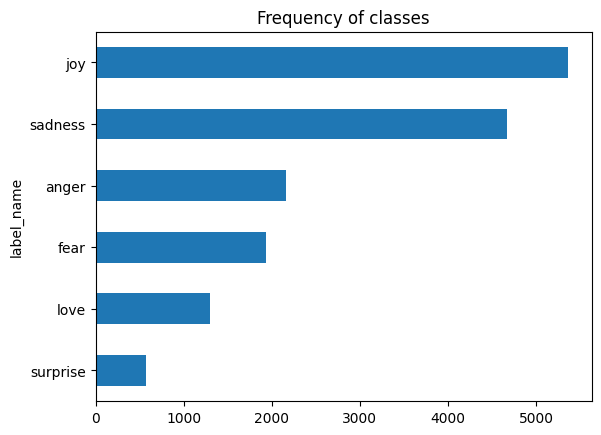

In [7]:
label_counts = df["label_name"].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of classes")
plt.show()

<Axes: title={'center': 'Words per Tweet'}, xlabel='label_name'>

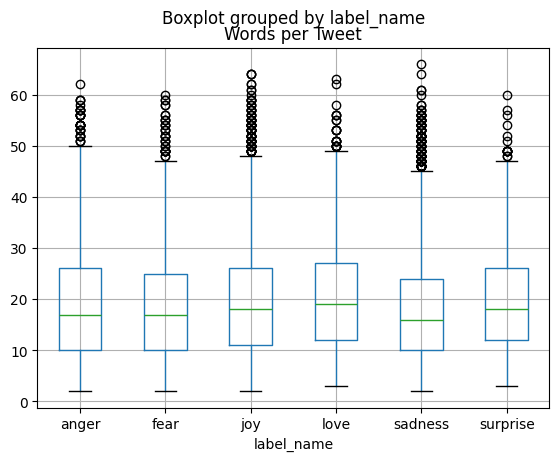

In [8]:
df["Words per Tweet"] = df["text"].apply(lambda x: len(x.split()))
df.boxplot("Words per Tweet", by="label_name")

In [9]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text="I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


C:\Users\te20312262\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
 # tokenizer.vocab is a dict
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size = 1/3, stratify=test["label_name"])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [12]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train': Dataset.from_pandas(train,preserve_index=False),
     'test': Dataset.from_pandas(test, preserve_index= False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
    })

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion/Sentiment Data

In [13]:
dataset['train'][0], dataset['test'][1]

({'text': 'i left feeling slightly dazed confused and disappointed',
  'label': 5,
  'label_name': 'surprise',
  'Words per Tweet': 8},
 {'text': 'i feel so dull and drowsy all the time',
  'label': 0,
  'label_name': 'sadness',
  'Words per Tweet': 9})

In [14]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True,max_length=512)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2187, 3110, 3621, 19720, 5457, 1998, 9364, 102, 0, 0, 0], [101, 1045, 2788, 2293, 3467, 2021, 2572, 3110, 1037, 15752, 2005, 3500, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [15]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [16]:
# label2id, id2label
label2id = {x['label_name'] : x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'surprise': 5, 'love': 2, 'anger': 3, 'joy': 1, 'fear': 4, 'sadness': 0},
 {5: 'surprise', 2: 'love', 3: 'anger', 1: 'joy', 4: 'fear', 0: 'sadness'})

## Model building

In [17]:
from transformers import AutoModel
import torch

In [18]:
model = AutoModel.from_pretrained(model_ckpt)

In [19]:
model.config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [20]:
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [21]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine Tuning Transformers

In [22]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [24]:
from transformers import TrainingArguments

batch_size =64
training_dir = 'bert_base_train_dir'
training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir=True,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False)

C:\Users\te20312262\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
#Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, reference=labels)

In [26]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1":f1}

In [27]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_encoded['train'],
                  eval_dataset=emotion_encoded['validation'],
                  tokenizer=tokenizer)

In [28]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.558868,0.820625,0.816185
2,No log,0.374488,0.875000,0.873473


CPU times: total: 15h 51min 45s
Wall time: 5h 22min 4s


TrainOutput(global_step=350, training_loss=0.7352435302734375, metrics={'train_runtime': 19323.1673, 'train_samples_per_second': 1.159, 'train_steps_per_second': 0.018, 'total_flos': 1001502421516800.0, 'train_loss': 0.7352435302734375, 'epoch': 2.0})

## Model Evaluation

In [29]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.31317853927612305,
 'test_accuracy': 0.8940625,
 'test_f1': 0.8923377756096907,
 'test_runtime': 22423.4491,
 'test_samples_per_second': 0.143,
 'test_steps_per_second': 0.002}

In [30]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       933
           1       0.90      0.94      0.92      1072
           2       0.80      0.64      0.71       261
           3       0.87      0.91      0.89       432
           4       0.86      0.87      0.86       387
           5       0.82      0.77      0.80       115

    accuracy                           0.89      3200
   macro avg       0.87      0.84      0.85      3200
weighted avg       0.89      0.89      0.89      3200



In [32]:
label2id

{'surprise': 5, 'love': 2, 'anger': 3, 'joy': 1, 'fear': 4, 'sadness': 0}

In [33]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

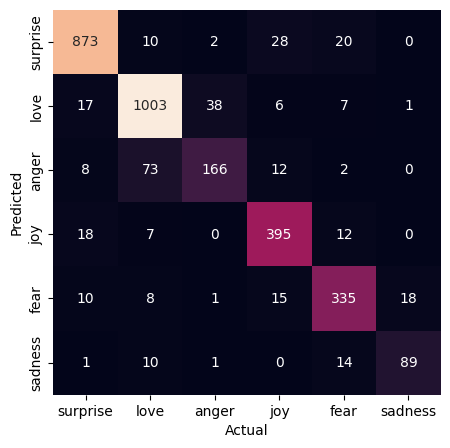

In [34]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,xticklabels=label2id.keys(),yticklabels=label2id.keys(), fmt='d', cbar=False)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## Build Prediction Funtion and store Model

In [35]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text,return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits,dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [36]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [37]:
# use pipeline for prediction
from transformers import pipeline

classifier = pipeline('text-classification', model='bert-base-uncased-sentiment-model')
classifier([text,'hello, how are you?', "love you", "i am feeling low"])

[{'label': 'joy', 'score': 0.9518903493881226},
 {'label': 'joy', 'score': 0.8351812362670898},
 {'label': 'love', 'score': 0.6861448884010315},
 {'label': 'sadness', 'score': 0.9635483026504517}]